This notebook is all about learning the functional form of an equation. The work here is based on a paper that I can't find anymore. Essentially, provide each linear layer a set of transcendental functions to operate on various outputs and multiply some together. Run the final layer through a division to approximate rational functions. Fun as a toy experiment, but not useful for me, because nothing I study can be represented in an analytic form.

In [1]:
import torch
from torch.utils.data import *
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def weird_function(x):
    return np.sin(x) + np.log(1+x) - np.exp(-x) + np.sqrt(x+1)

In [6]:
spacing = .2
stop = 10
test = np.arange(0,stop,spacing)
num_data = len(test)
num_samples = 1000
y_data = torch.zeros(num_samples,num_data,dtype=torch.float)
x_data = torch.zeros(num_samples,num_data,dtype=torch.float)
for i in range(num_samples):
    x = np.arange(0,stop,spacing)
    x += np.random.randn(*x.shape)/100
    x = np.random.permutation(x)
    x_data[i,:] = torch.tensor(x)
    y = weird_function(x)
    y += np.random.randn(*y.shape)/100
    y_data[i,:] = torch.tensor(y)
x_data = x_data.cuda()
y_data = y_data.cuda()
# y_mean = torch.mean(y_data)
# y_std = torch.std(y_data)
# y_data = (y_data-y_mean)/y_std

In [4]:
ds = TensorDataset(y_data)
dl = DataLoader(ds,batch_size=100,shuffle=True)

In [338]:
x = np.arange(0,stop,spacing)
y_actual = weird_function(x)
y_act = torch.tensor(y_actual)[None,:].float().cuda()
y_act = (y_act-y_mean)/y_std
y_actual = (y_actual-y_mean.numpy())/y_std.numpy()

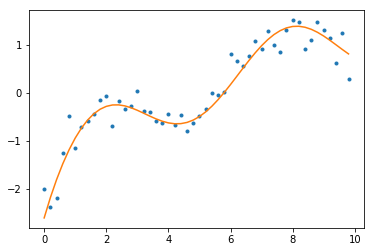

In [339]:
idx = np.random.choice(range(num_samples))
plt.figure()
plt.plot(x,y_data[idx].data.numpy(),'.')
plt.plot(x,y_actual)
plt.show()

In [21]:
num_forward = 0

In [204]:
class test_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.start = nn.Linear(1,30)
        self.L1 = nn.Linear(24,30)
        self.L2 = nn.Linear(24,30)
        self.L3 = nn.Linear(24,30)
        self.end = nn.Linear(30,2)
        
    def forward(self,x):
        x = self.start(x)
        x = self.functional_transform(x)
        x = self.L1(x)
        x = self.functional_transform(x)
        x = self.L2(x)
        x = self.functional_transform(x)
        x = self.L3(x)
        x = self.end(x)
        return self.division(x)
    
    def functional_transform(self, x):
        h_size = 30
        num_per_function = h_size//5
#         y = torch.Variable(x[:,:h_size-num_per_function].data.clone(), requires_grad=True)
        y = torch.zeros_like(x[:,:h_size-num_per_function])
        for i in range(num_per_function,h_size-num_per_function,num_per_function):
            if i//num_per_function == 1:
                y[:,i:i+num_per_function] = torch.sin(x[:,i:i+num_per_function])
            if i//num_per_function == 2:
                y[:,i:i+num_per_function] = torch.cos(x[:,i:i+num_per_function])
            if i//num_per_function == 3:
                y[:,i:i+num_per_function] = x[:,i:i+num_per_function]*x[:,i+num_per_function:i+2*num_per_function]
        return y
#         return x[:,:h_size-num_per_function]
    
    def division(self, x):
        y = torch.zeros_like(x[:,::2])
        eps = 1e-8
        y = x[:,::2]/(x[:,1::2]+eps)
        y *= (x[:,1::2]>0.5).float()
        return y
            

In [20]:
rnn_length = num_data

In [205]:
model = test_model().cuda()
lr_start = 1e-6
opt = torch.optim.Adam(model.parameters(),weight_decay=0.00)
criterion = nn.MSELoss()
loss_list = []

In [199]:
opt = torch.optim.Adam(model.parameters(),weight_decay=0.001)

In [206]:
model.train()
opt.param_groups[0]['lr'] = 1e-2
for _ in range(500):
#     for i in range(x_data.shape[0]):
    start = np.random.choice(range(num_data))
    opt.zero_grad()
    y_pred = model(x_data[:,start].view(-1,1))
#         loss = criterion(y_pred,data[:,start+rnn_length-num_forward:start+rnn_length])
    loss = criterion(y_pred,y_data[:,start].view(-1,1))
    loss.backward()
    opt.step()
    loss_list.append(loss.item()/x_data.shape[0])

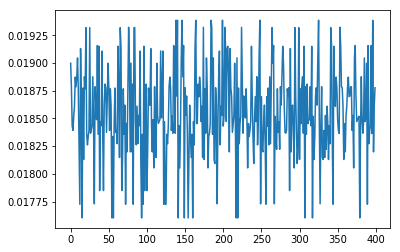

In [207]:
plt.plot(loss_list[100:])

In [22]:
model.eval()
idx = np.random.choice(range(num_samples))
model_pred = y_data[idx,:rnn_length-num_forward].cuda()
cur_y = model_pred
num_future = 30
for i in range(num_future):
    y_next = model(cur_y.view(1,-1)).view(-1)
    model_pred = torch.cat((model_pred,y_next[0].view(-1)))
    cur_y = model_pred[i+1:rnn_length+i]
model_pred = model_pred.cpu()
plt.figure()
plt.plot(x,y_data[idx].data.numpy(),'.')
# x_extend = np.r_[x,np.linspace(x[-1]+spacing,x[-1]+(num_future-num_forward+1)*spacing,num_future-num_forward)]
x_extend = x[:rnn_length+num_future-num_forward]
plt.plot(x_extend,model_pred.data.numpy(),'o',fillstyle='none',markeredgewidth=2)
plt.plot(x_extend,weird_function(x_extend))
plt.show()

RuntimeError: size mismatch, m1: [1 x 50], m2: [1 x 30] at c:\a\w\1\s\tmp_conda_3.6_173528\conda\conda-bld\pytorch_1549561085620\work\aten\src\thc\generic/THCTensorMathBlas.cu:266

In [23]:
model.eval()
idx = np.random.choice(range(num_samples))
model_pred = y_data[idx,:rnn_length-num_forward].cuda()
# model_pred = torch.randn_like(model_pred)
cur_y = model_pred
num_future = 1
for i in range(num_future):
    y_next = model(cur_y.view(1,-1)).view(-1)
#     model_pred = torch.cat((model_pred,y_next))
    cur_y = model_pred[(i+1)*num_forward:rnn_length+i*num_forward]
model_pred = model_pred.cpu()
plt.figure()
plt.plot(x,y_data[idx].data.numpy(),'.')
# x_extend = np.r_[x,np.linspace(x[-1]+spacing,x[-1]+(num_future-1)*num_forward*spacing,(num_future-1)*num_forward)]
# x_extend = x[:rnn_length+(num_future-1)*num_forward]
x_extend = x
plt.plot(x_extend,y_next.data.cpu().numpy(),'o',fillstyle='none',markeredgewidth=2)
plt.plot(x_extend,(weird_function(x_extend)-y_mean.numpy())/y_std.numpy())
plt.show()

RuntimeError: size mismatch, m1: [1 x 50], m2: [1 x 30] at c:\a\w\1\s\tmp_conda_3.6_173528\conda\conda-bld\pytorch_1549561085620\work\aten\src\thc\generic/THCTensorMathBlas.cu:266

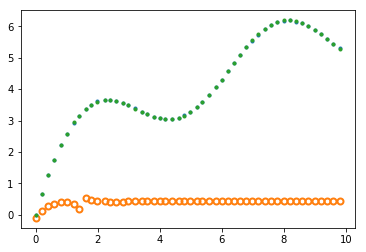

In [202]:
model.eval()
idx = np.random.choice(range(num_samples))
y_model = np.zeros(num_data)
y_actual = np.zeros(num_data)
y_noisy = np.zeros(num_data)
for i in range(num_data):
    y_noisy[i] = y_data[idx,i].cpu().data.numpy()
    y_model[i] = model(x_data[idx,i].view(1,1)).cpu().data.numpy()
    y_actual[i] = weird_function(x_data[idx,i].view(1,1).cpu().data.numpy())
x = x_data[idx,:].cpu().data.numpy()

plt.figure()
plt.plot(x,y_noisy,'.')
plt.plot(x,y_model,'o',fillstyle='none',markeredgewidth=2)
plt.plot(x,y_actual,'.')

C:\Users\joshu\Miniconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  
C:\Users\joshu\Miniconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


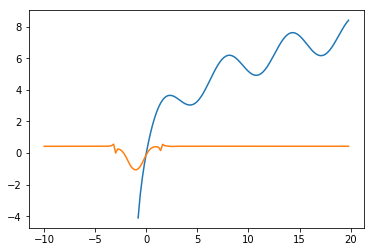

In [203]:
x_extrap = torch.tensor(np.arange(-stop,2*stop,spacing)).cuda()
plt.plot(x_extrap.data.cpu().numpy(),weird_function(x_extrap.data.cpu().numpy()))
plt.plot(x_extrap.data.cpu().numpy(),model(x_extrap.view(-1,1).float()).view(-1).data.cpu().numpy())

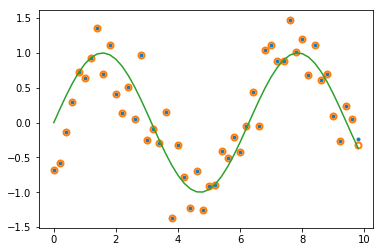

In [172]:

plt.figure()
plt.plot(x,y_data[idx].data.numpy(),'.')
plt.plot(x,list(y_data[idx,:-1].data.numpy())+list(model(y_data[idx,:-1].view(1,-1)).view(-1).data.numpy()),'o',fillstyle='none',markeredgewidth=2)
plt.plot(x,y_actual)
plt.show()

In [295]:
y_act[:,-1].shape

torch.Size([1])

In [332]:
torch.sum((y_data[:,-1]-y_act[0,-1])**2)

tensor(111.9317)

In [336]:
torch.sum((model(y_data[:,:-1])-y_act[:,-1])**2)/1000

tensor(0.0027, grad_fn=<DivBackward0>)

In [335]:
criterion(model(y_data[:,:-1]),y_act[:,-1])

tensor(0.0027, grad_fn=<MseLossBackward>)

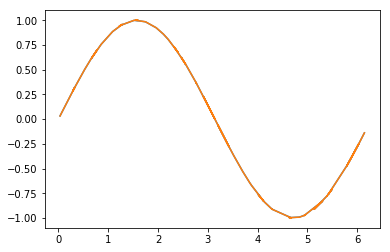

In [70]:

plt.plot(x,model(torch.tensor(y)[None,:].float()).view(-1).data.numpy())
plt.plot(x,y_actual)